101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.
/Users/kenny_jung/aiffel/news_crawler/news_data.csv File Saved!
훈련용 뉴스 기사의 개수   : 4576
테스트용 뉴스 기사의 개수 :  1526
훈련용 레이블의 개수      :  4576
테스트용 레이블의 개수    :  1526
전체 레이블의 개수        :  6102
              precision    recall  f1-score   support

       IT/과학       0.72      0.62      0.67       248
          경제       0.64      0.76      0.69       465
          사회       0.76      0.78      0.77       440
       생활/문화       0.75      0.63      0.69       373

    accuracy                           0.71      1526
   macro avg       0.72      0.70      0.70      1526
weighted avg       0.72      0.71      0.71      1526



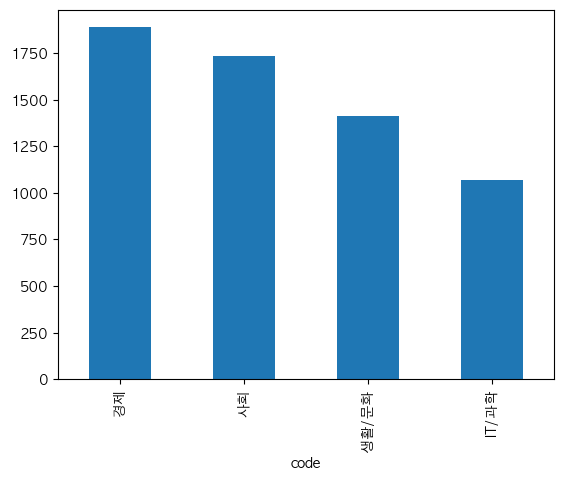

In [2]:
#도구들을 임포트합니다.
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from newspaper import Article
from konlpy.tag import Mecab
from matplotlib import rc

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
    urllist= []
    for i in range(1, page_num + 1):
        url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
        headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
        news = requests.get(url, headers=headers)

        # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
        soup = BeautifulSoup(news.content, 'html.parser')

        # CASE 1
        news_list = soup.select('.newsflash_body .type06_headline li dl')
        # CASE 2
        news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
        # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
        for line in news_list:
            urllist.append(line.a.get('href'))
    return urllist


idx2word = {'100' : '정치', '101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}


#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
    text_list = []
    for url in urllist:
        article = Article(url, language='ko')
        article.download()
        article.parse()
        text_list.append(article.title)

    #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
    df = pd.DataFrame({'news': text_list})

    #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
    df['code'] = idx2word[str(code)]
    return df


#- 데이터프레임을 생성하는 함수입니다.
def make_total_data(page_num, code_list, date):
    df = None

    for code in code_list:
        url_list = make_urllist(page_num, code, date)
        df_temp = make_data(url_list, code)
        print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

        if df is not None:
            df = pd.concat([df, df_temp])
        else:
            df = df_temp

    return df


# 대상 카테고리 코드
# 100: 정치, 101: 경제, 102: 사회, 103: 생활/문화, 105: IT/과학
code_list = [101, 102, 103, 105]


# 특정 날짜 대상 News Category의 News Dataframe 생성
df = make_total_data(100, code_list, 20240108)


# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
csv_path = "/Users/kenny_jung/aiffel/news_crawler/news_data.csv"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
    print('{} File Saved!'.format(csv_path))


#데이터 전처리
df = pd.read_table(csv_path, sep=',')

# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


# csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
csv_path = "/Users/kenny_jung/aiffel/news_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',')

# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

from konlpy.tag import Mecab  
tokenizer = Mecab('/opt/homebrew/lib/mecab/dic/mecab-ko-dic')

#               precision    recall  f1-score   support

#        IT/과학       0.73      0.82      0.77       390
#           사회       0.80      0.81      0.80       439
#        생활/문화       0.76      0.66      0.71       455

#     accuracy                           0.76      1284
#    macro avg       0.76      0.76      0.76      1284
# weighted avg       0.76      0.76      0.76      1284

# from konlpy.tag import Komoran
# tokenizer = Komoran()

#               precision    recall  f1-score   support

#        IT/과학       0.72      0.83      0.77       390
#           사회       0.81      0.79      0.80       439
#        생활/문화       0.75      0.68      0.71       455

#     accuracy                           0.76      1284
#    macro avg       0.76      0.77      0.76      1284
# weighted avg       0.76      0.76      0.76      1284


# from konlpy.tag import Okt             
# tokenizer = Okt()

#               precision    recall  f1-score   support

#        IT/과학       0.72      0.83      0.77       390
#           사회       0.79      0.79      0.79       439
#        생활/문화       0.76      0.66      0.71       455

#     accuracy                           0.76      1284
#    macro avg       0.76      0.76      0.76      1284
# weighted avg       0.76      0.76      0.75      1284

# from konlpy.tag import Kkma
# tokenizer = Kkma()

#               precision    recall  f1-score   support

#        IT/과학       0.71      0.83      0.76       390
#           사회       0.82      0.80      0.81       439
#        생활/문화       0.75      0.66      0.70       455

#     accuracy                           0.76      1284
#    macro avg       0.76      0.76      0.76      1284
# weighted avg       0.76      0.76      0.76      1284


stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수', '무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스', '날', '무상', '원', '억', '도', '어', '나', '것', '살', '야', '만', '중', '라', '아', '기', '찬', '간', '상', '개', '곳', '어', '로', '합니다', '와', '년', '새', '서', '화', '공개', '환', '화', '서']

# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
    text_data = []

    for index, sentence in enumerate(data):
        try:
            #- 토큰화
            temp_data = tokenizer.morphs(sentence)
            #- 불용어 제거
            temp_data = [word for word in temp_data if word not in stopwords]
            text_data.append(' '.join(temp_data))
        except Exception as e:
#             print(f"Error at index {index}: {sentence}\nError: {e}")
            text_data.append('')  # Append an empty string or some placeholder
            continue  # Continue with the next iteration

    return text_data

text_data = preprocessing(df['news'])


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

# 전체 레이블 개수와 훈련용 레이블 개수를 확인합니다.
print('훈련용 뉴스 기사의 개수   :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수      : ', len(y_train))
print('테스트용 레이블의 개수    : ', len(y_test))
print('전체 레이블의 개수        : ', len(y_train)+len(y_test))

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "AppleGothic"
df['code'].value_counts().plot(kind = 'bar')

#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))